MSDS 684 - Lab 2: Dynamic Programming on GridWorld and FrozenLake-v1

- Custom GridWorldEnv (Gymnasium API)
- Policy Evaluation (synchronous + in-place)
- Policy Iteration
- Value Iteration (synchronous + in-place)
- Visualizations:
  * Value function heatmaps
  * Policy quiver plots (arrows)
  * Convergence curves (delta vs iteration and wall-clock time)
- Tests:
  * Deterministic GridWorld
  * Stochastic GridWorld
  * FrozenLake-v1 using env.unwrapped.P

=== GridWorld Experiments ===

--- Config: deterministic ---
Running Policy Iteration (in-place)...
Running Policy Iteration (sync)...


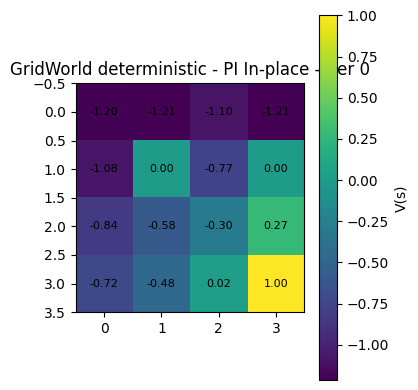

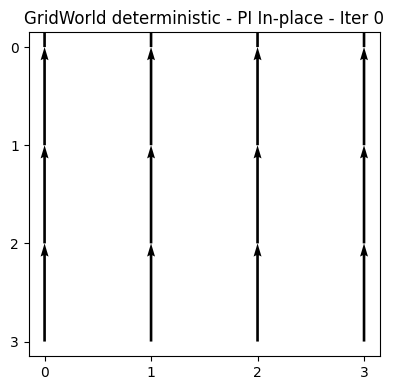

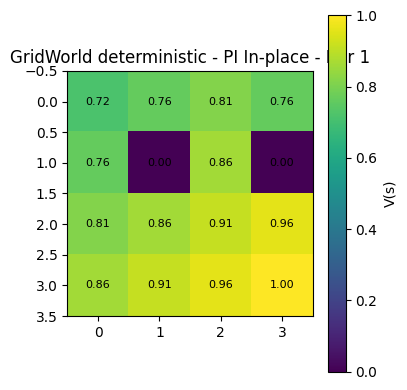

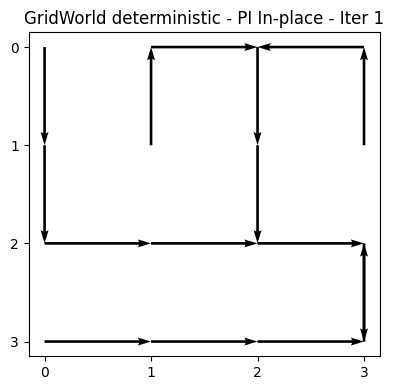

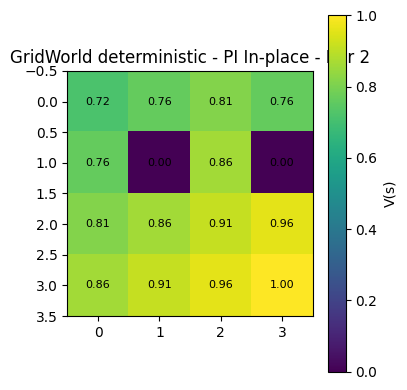

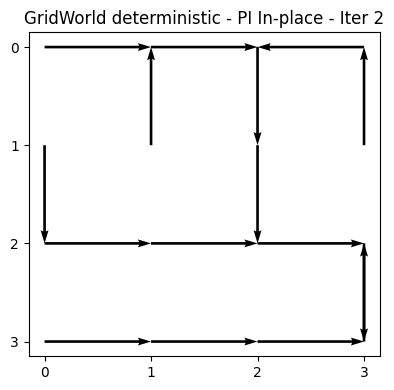

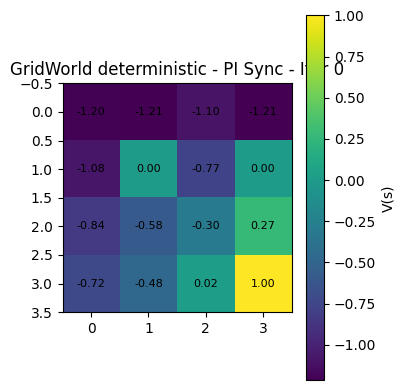

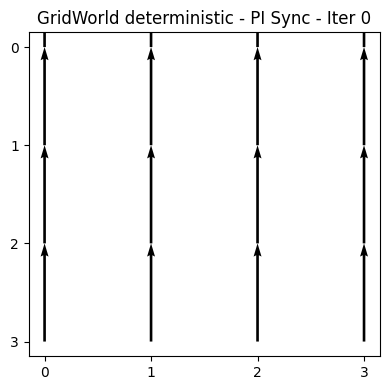

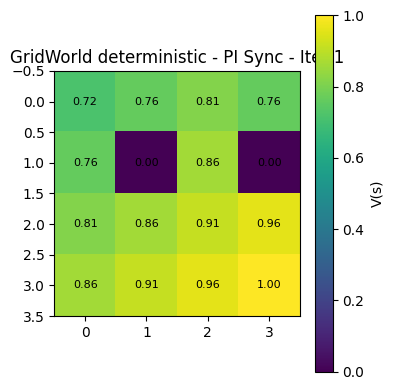

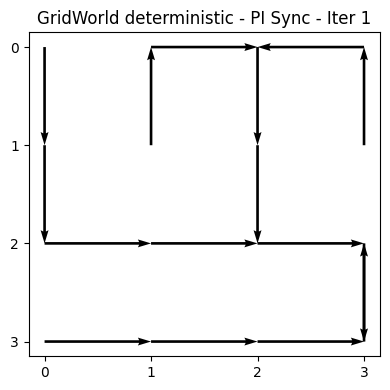

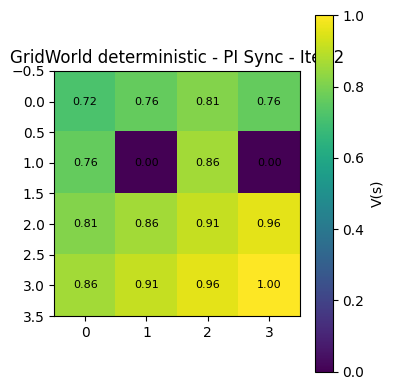

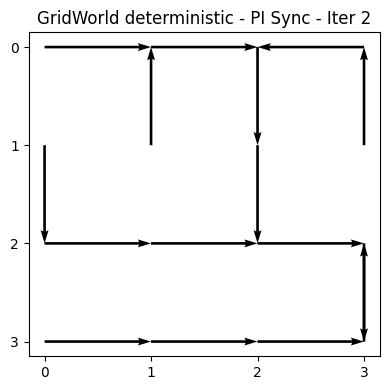

Running Value Iteration (in-place)...
Running Value Iteration (sync)...


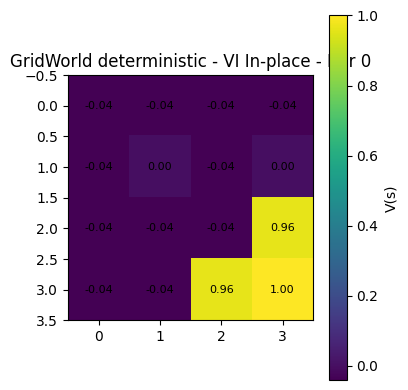

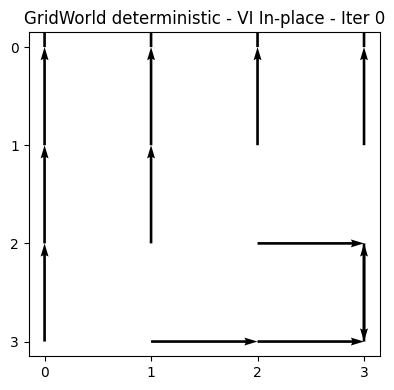

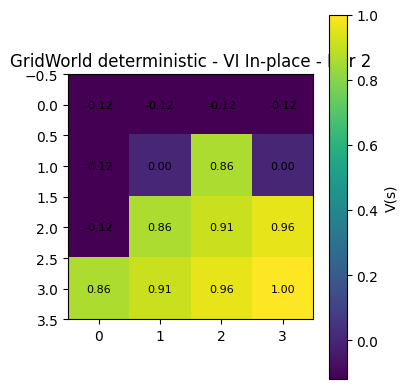

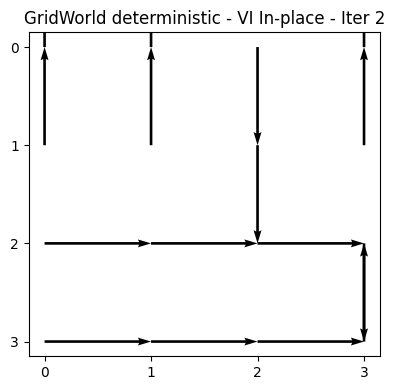

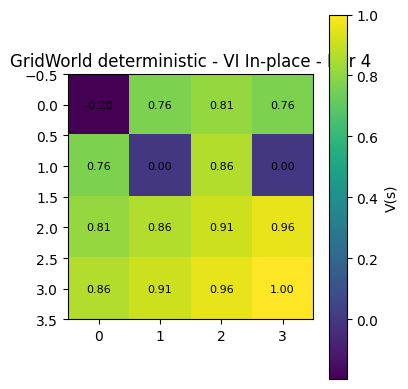

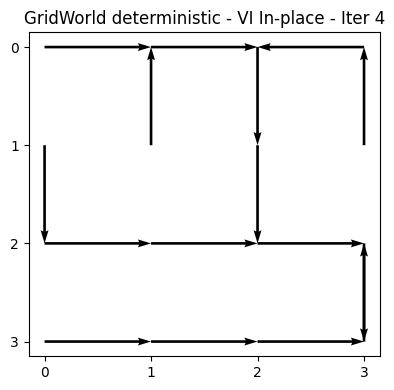

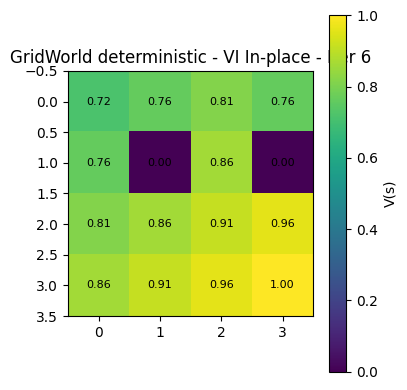

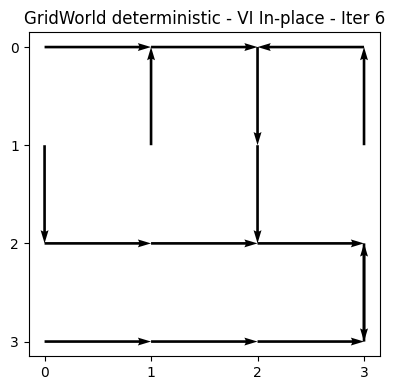

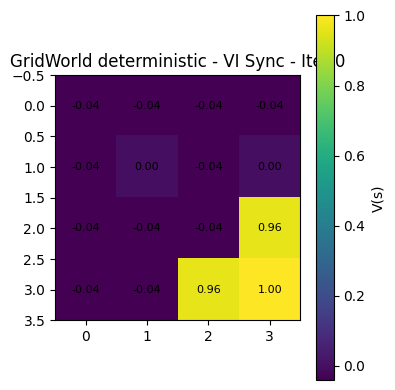

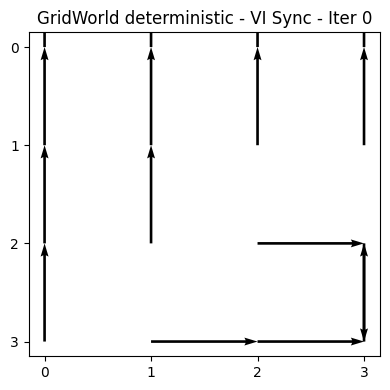

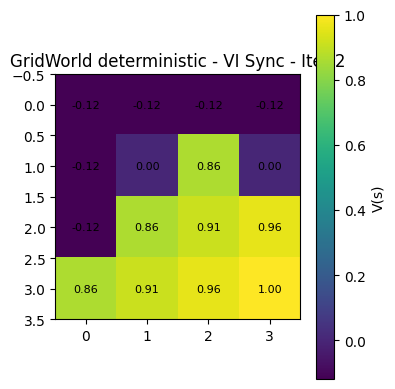

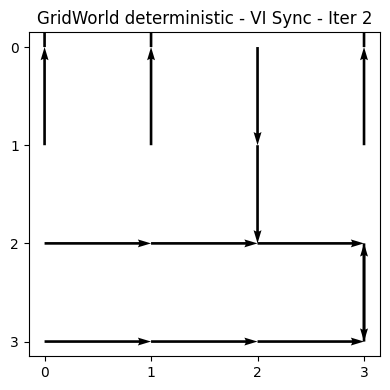

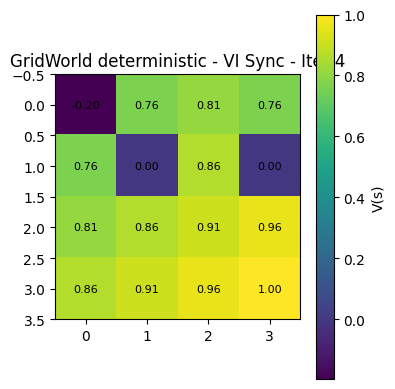

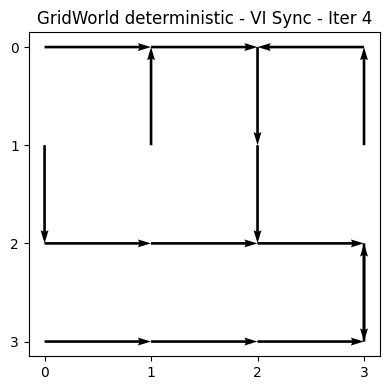

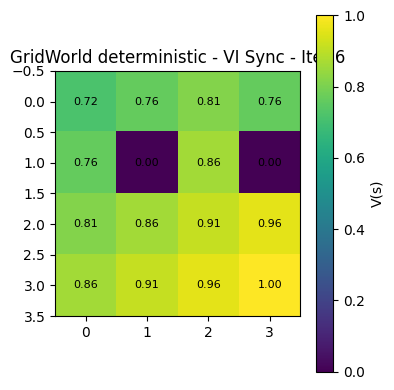

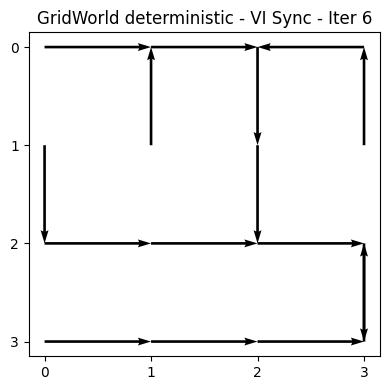

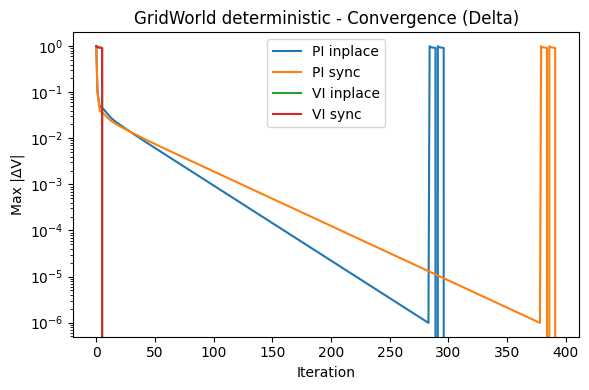

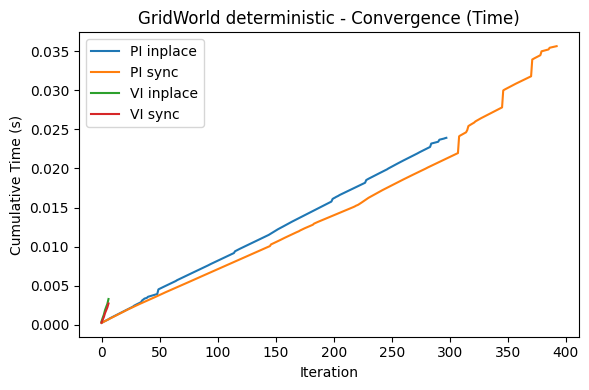

PI inplace: final Δ=0.00e+00, sweeps=298
PI sync:    final Δ=0.00e+00, sweeps=393
VI inplace: final Δ=0.00e+00, sweeps=7
VI sync:    final Δ=0.00e+00, sweeps=7

--- Config: stochastic ---
Running Policy Iteration (in-place)...
Running Policy Iteration (sync)...


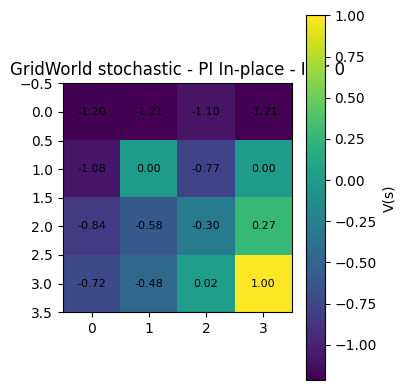

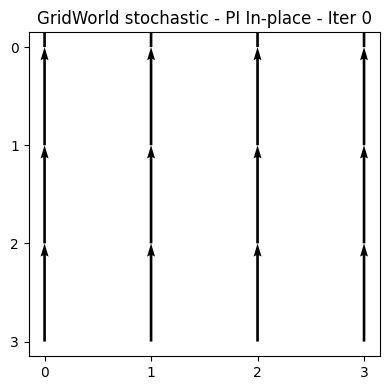

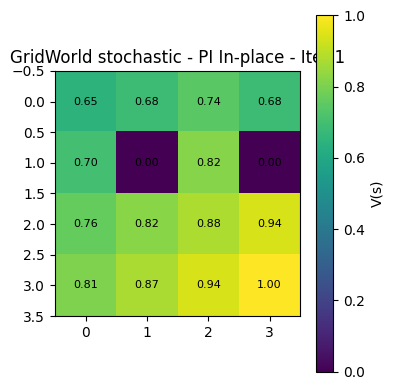

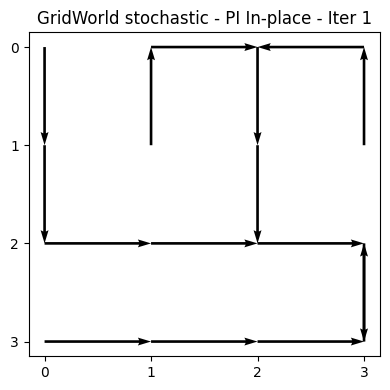

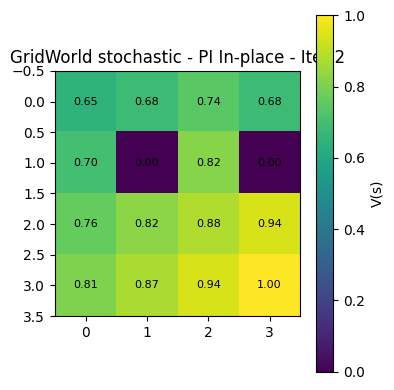

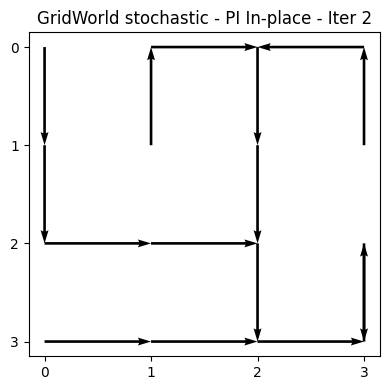

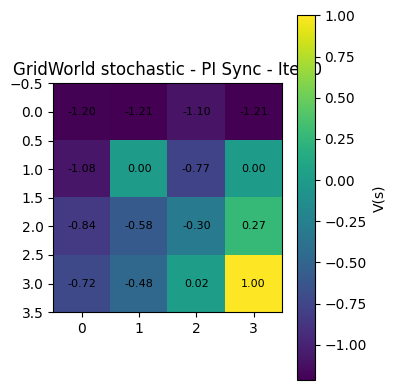

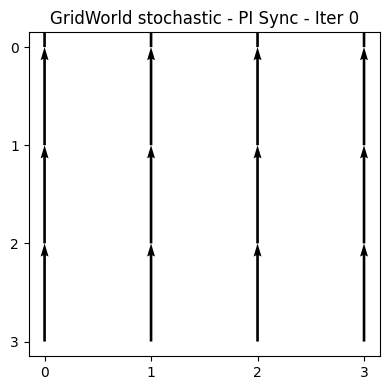

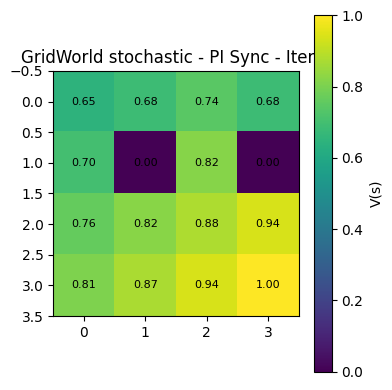

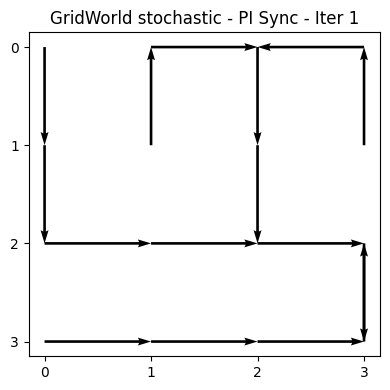

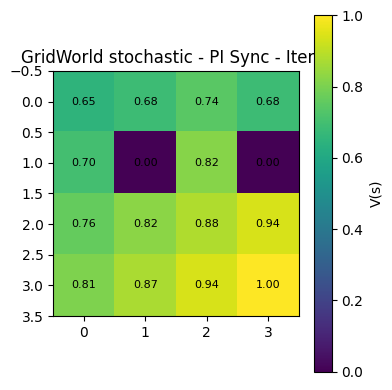

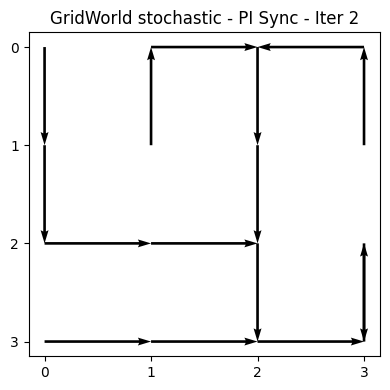

Running Value Iteration (in-place)...
Running Value Iteration (sync)...


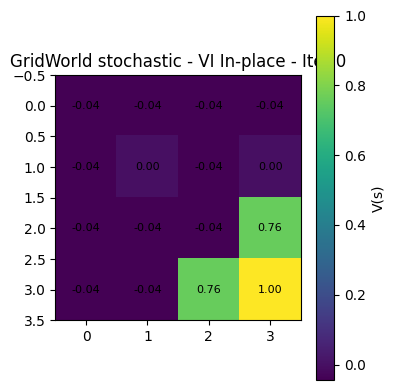

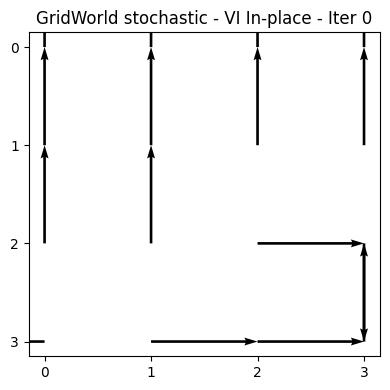

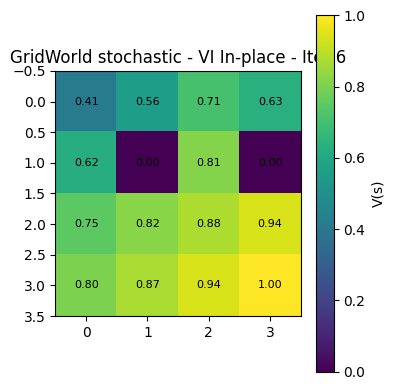

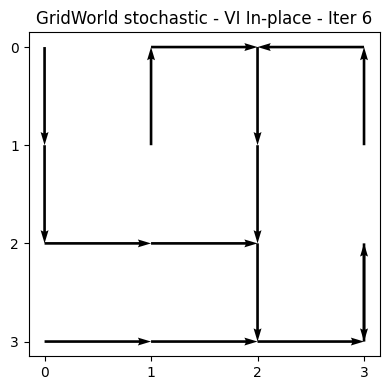

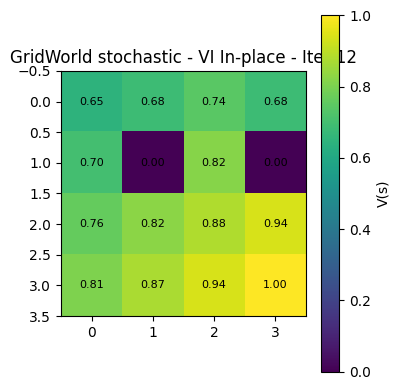

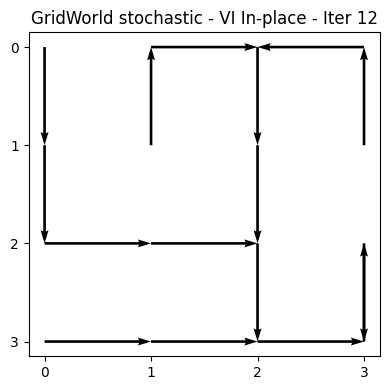

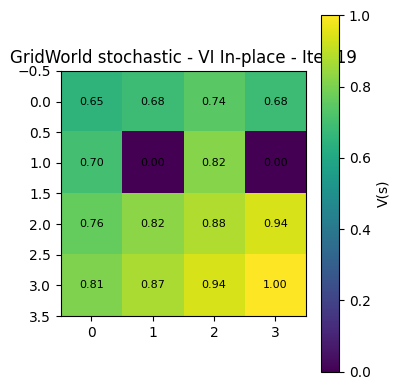

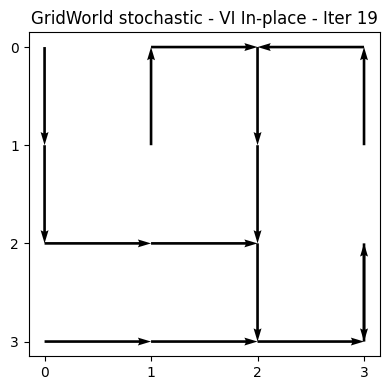

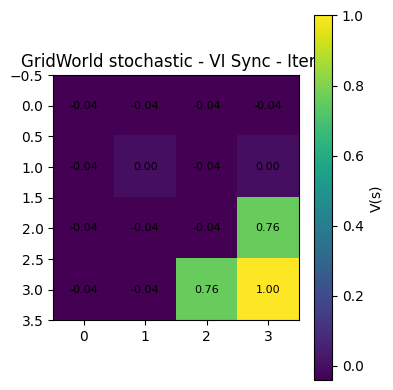

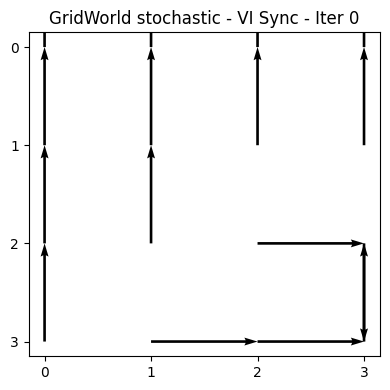

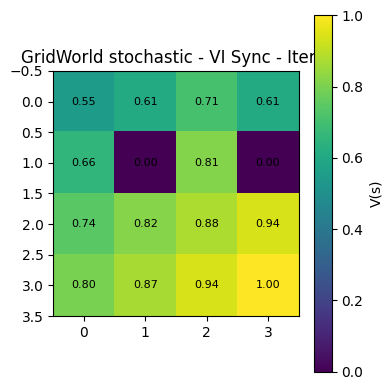

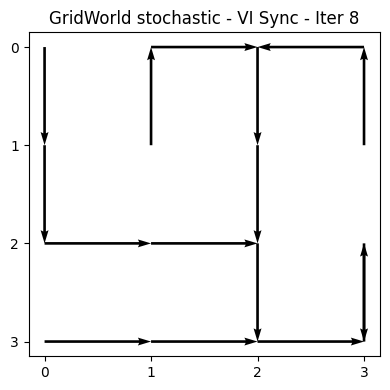

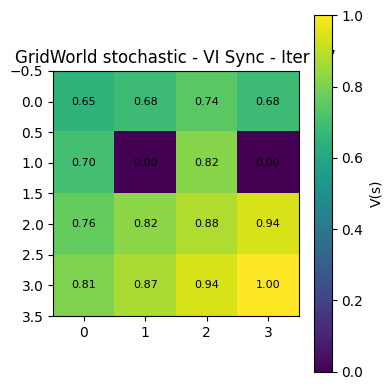

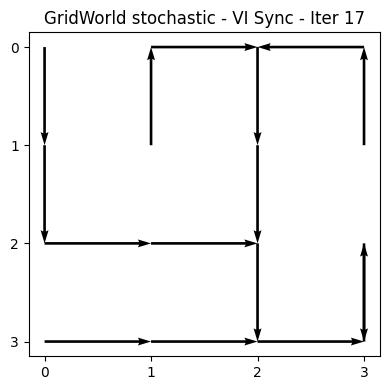

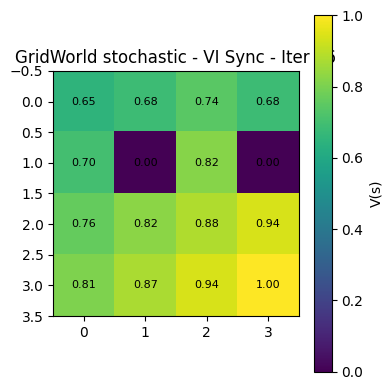

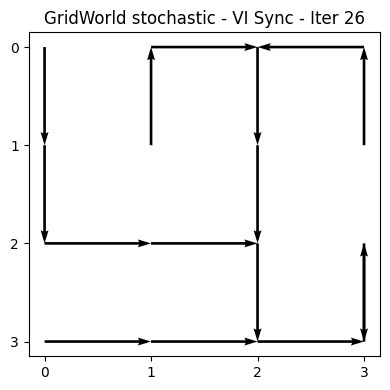

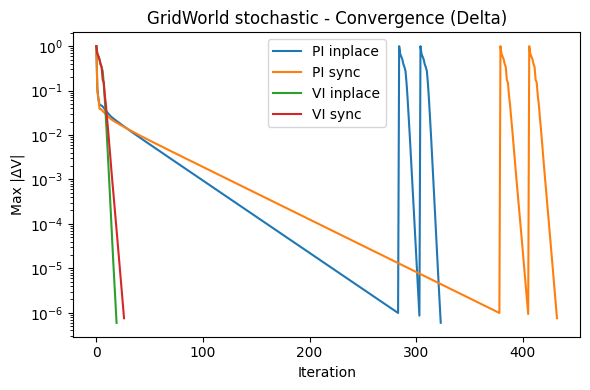

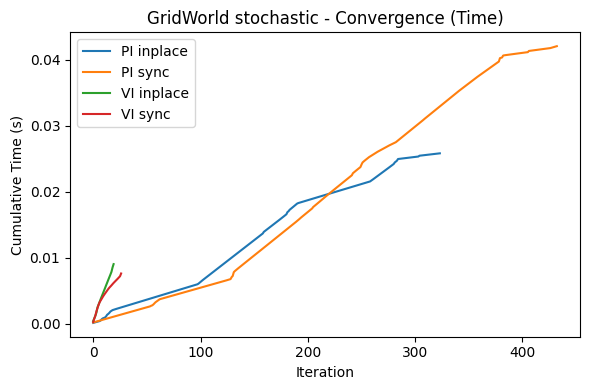

PI inplace: final Δ=5.94e-07, sweeps=324
PI sync:    final Δ=7.51e-07, sweeps=433
VI inplace: final Δ=5.90e-07, sweeps=20
VI sync:    final Δ=7.51e-07, sweeps=27

=== FrozenLake Experiments ===
Running Value Iteration...
Running Policy Iteration...


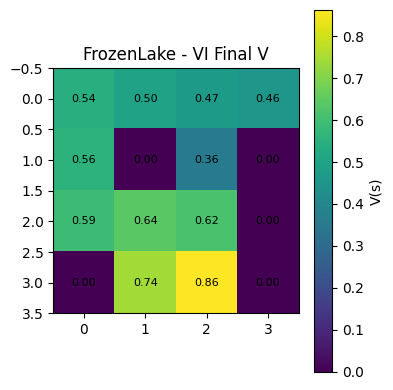

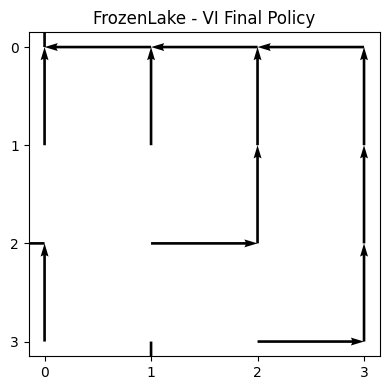

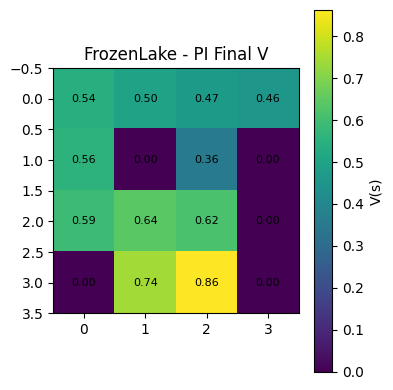

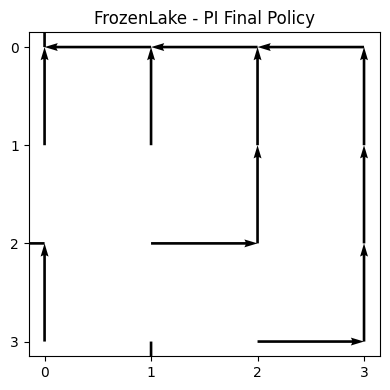

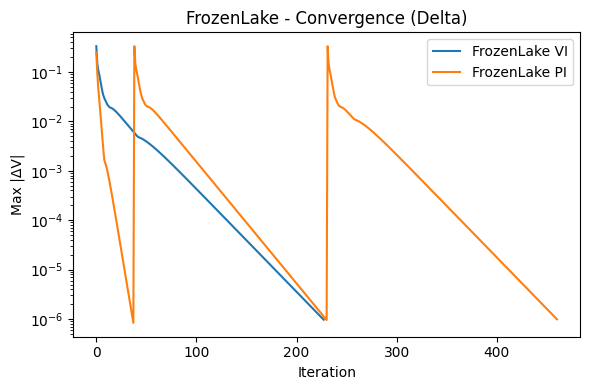

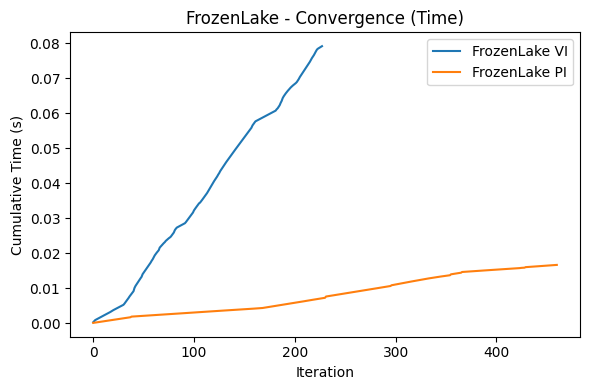

FrozenLake VI: final Δ=9.72e-07, sweeps=228
FrozenLake PI: final Δ=9.89e-07, sweeps=461

All experiments completed!


In [4]:
import time
import os
from typing import Dict, List, Tuple

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces



# Utility

def set_seed(seed: int = 42):
    np.random.seed(seed)


def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)



# Custom GridWorld Environment (Gymnasium API)
class GridWorldEnv(gym.Env):
    """
    Simple GridWorld with configurable:
    - size (rows, cols)
    - terminal states and rewards
    - obstacles
    - step cost
    - stochastic transitions (slip to perpendicular actions)
    Gymnasium-style Discrete state/action spaces with tabular P(s,a,s',r,done).
    """

    metadata = {"render_modes": []}

    def __init__(
        self,
        shape: Tuple[int, int] = (4, 4),
        start_state: int = 0,
        terminal_states: Dict[int, float] = None,
        obstacle_states: List[int] = None,
        step_cost: float = -0.04,
        stochastic: bool = False,
        intended_prob: float = 0.8,
    ):
        super().__init__()

        self.rows, self.cols = shape
        self.nS = self.rows * self.cols
        self.nA = 4  # 0: up, 1: right, 2: down, 3: left

        self.action_space = spaces.Discrete(self.nA)
        self.observation_space = spaces.Discrete(self.nS)

        self.start_state = start_state
        self.current_state = start_state

        if terminal_states is None:
            terminal_states = {self.nS - 1: 1.0}
        self.terminal_states = terminal_states

        if obstacle_states is None:
            obstacle_states = []
        self.obstacle_states = set(obstacle_states)

        self.step_cost = step_cost
        self.stochastic = stochastic
        self.intended_prob = intended_prob

        # Build transition model P[s][a]
        self.P: Dict[int, Dict[int, List[Tuple[float, int, float, bool]]]] = {}
        self._build_transition_model()


    # Helpers
    def to_pos(self, s: int) -> Tuple[int, int]:
        return s // self.cols, s % self.cols

    def to_state(self, r: int, c: int) -> int:
        return r * self.cols + c

    def in_bounds(self, r: int, c: int) -> bool:
        return 0 <= r < self.rows and 0 <= c < self.cols

    def is_terminal(self, s: int) -> bool:
        return s in self.terminal_states

    def is_obstacle(self, s: int) -> bool:
        return s in self.obstacle_states

    def _move(self, s: int, a: int) -> int:
        if self.is_terminal(s):
            return s

        r, c = self.to_pos(s)
        if a == 0:
            nr, nc = r - 1, c
        elif a == 1:
            nr, nc = r, c + 1
        elif a == 2:
            nr, nc = r + 1, c
        else:
            nr, nc = r, c - 1

        if not self.in_bounds(nr, nc):
            return s

        ns = self.to_state(nr, nc)
        if self.is_obstacle(ns):
            return s
        return ns

    def _build_transition_model(self):
        self.P = {s: {a: [] for a in range(self.nA)} for s in range(self.nS)}

        for s in range(self.nS):
            if self.is_obstacle(s):
                for a in range(self.nA):
                    self.P[s][a] = [(1.0, s, 0.0, False)]
                continue

            if self.is_terminal(s):
                reward = self.terminal_states[s]
                for a in range(self.nA):
                    self.P[s][a] = [(1.0, s, reward, True)]
                continue

            for a in range(self.nA):
                transitions = []

                if not self.stochastic:
                    ns = self._move(s, a)
                    reward = self.step_cost
                    if self.is_terminal(ns):
                        reward += self.terminal_states[ns]
                    done = self.is_terminal(ns)
                    transitions.append((1.0, ns, reward, done))
                else:
                    intended = a
                    if a in [0, 2]:
                        perpendiculars = [3, 1]
                    else:
                        perpendiculars = [0, 2]

                    probs = [self.intended_prob,
                             (1 - self.intended_prob)/2,
                             (1 - self.intended_prob)/2]

                    actions = [intended] + perpendiculars

                    for pa, aa in zip(probs, actions):
                        ns = self._move(s, aa)
                        reward = self.step_cost
                        if self.is_terminal(ns):
                            reward += self.terminal_states[ns]
                        done = self.is_terminal(ns)
                        transitions.append((pa, ns, reward, done))

                self.P[s][a] = transitions


    # Gymnasium API
    def reset(self, seed: int = None, options: dict = None):
        super().reset(seed=seed)
        self.current_state = self.start_state
        return self.current_state, {}

    def step(self, action: int):
        transitions = self.P[self.current_state][action]
        probs = [t[0] for t in transitions]
        idx = np.random.choice(len(transitions), p=probs)
        prob, next_state, reward, done = transitions[idx]
        self.current_state = next_state
        return next_state, reward, done, False, {}

    def render(self):
        grid = np.full((self.rows, self.cols), " . ")
        for s, r in self.terminal_states.items():
            rr, cc = self.to_pos(s)
            grid[rr, cc] = "T+ " if r > 0 else "T- "
        for s in self.obstacle_states:
            rr, cc = self.to_pos(s)
            grid[rr, cc] = "###"
        rr, cc = self.to_pos(self.current_state)
        grid[rr, cc] = " A "
        print("\n".join("".join(row) for row in grid))



# DP Helpers

def policy_evaluation(
    P, nS, nA, policy, gamma=0.99, theta=1e-6, max_iterations=1000, in_place=True
):
    V = np.zeros(nS)
    V_history = []
    deltas = []
    times = []

    t0 = time.time()

    for it in range(max_iterations):
        delta = 0.0

        if in_place:
            for s in range(nS):
                v_old = V[s]
                v_new = 0.0
                for a in range(nA):
                    pa = policy[s, a]
                    if pa == 0:
                        continue
                    for prob, ns, reward, done in P[s][a]:
                        v_new += pa * prob * (reward + gamma * (0 if done else V[ns]))
                V[s] = v_new
                delta = max(delta, abs(v_old - v_new))

        else:
            V_new = np.zeros(nS)
            for s in range(nS):
                v_new = 0.0
                for a in range(nA):
                    pa = policy[s, a]
                    if pa == 0:
                        continue
                    for prob, ns, reward, done in P[s][a]:
                        v_new += pa * prob * (reward + gamma * (0 if done else V[ns]))
                V_new[s] = v_new
                delta = max(delta, abs(V[s] - v_new))
            V = V_new

        V_history.append(V.copy())
        deltas.append(delta)
        times.append(time.time() - t0)

        if delta < theta:
            break

    return V, V_history, np.array(deltas), np.array(times)


def greedy_policy_from_V(P, nS, nA, V, gamma=0.99):
    policy = np.zeros((nS, nA))
    for s in range(nS):
        q = np.zeros(nA)
        for a in range(nA):
            for prob, ns, reward, done in P[s][a]:
                q[a] += prob * (reward + gamma * (0 if done else V[ns]))
        best = np.argmax(q)
        policy[s, best] = 1.0
    return policy


def policy_improvement(P, nS, nA, V, gamma, policy):
    new_policy = np.zeros_like(policy)
    stable = True

    for s in range(nS):
        old = np.argmax(policy[s])
        q = np.zeros(nA)
        for a in range(nA):
            for prob, ns, reward, done in P[s][a]:
                q[a] += prob * (reward + gamma*(0 if done else V[ns]))
        best = np.argmax(q)
        new_policy[s, best] = 1.0
        if best != old:
            stable = False

    return new_policy, stable


def policy_iteration(
    P, nS, nA, gamma=0.99, theta=1e-6, max_policy_iterations=100, eval_in_place=True
):
    policy = np.ones((nS, nA)) / nA
    V_history = []
    policy_history = []
    deltas_all = []
    times_all = []

    t0_global = time.time()

    for it in range(max_policy_iterations):
        V, V_hist, deltas_eval, t_eval = policy_evaluation(
            P, nS, nA, policy, gamma, theta, in_place=eval_in_place
        )

        V_history.append(V.copy())
        policy_history.append(policy.copy())
        deltas_all.extend(deltas_eval.tolist())
        times_all.extend((t_eval + (time.time() - t0_global - t_eval[-1])).tolist())

        new_policy, stable = policy_improvement(P, nS, nA, V, gamma, policy)
        policy = new_policy

        if stable:
            break

    return (
        V,
        policy,
        V_history,
        policy_history,
        np.array(deltas_all),
        np.array(times_all),
    )


def value_iteration(
    P, nS, nA, gamma=0.99, theta=1e-6, max_iterations=1000, in_place=True
):
    V = np.zeros(nS)
    V_history = []
    policy_history = []
    deltas = []
    times = []
    t0 = time.time()

    for it in range(max_iterations):
        delta = 0

        if in_place:
            for s in range(nS):
                v_old = V[s]
                q = np.zeros(nA)
                for a in range(nA):
                    for prob, ns, reward, done in P[s][a]:
                        q[a] += prob * (reward + gamma * (0 if done else V[ns]))
                V[s] = np.max(q)
                delta = max(delta, abs(v_old - V[s]))

        else:
            V_new = np.zeros(nS)
            for s in range(nS):
                q = np.zeros(nA)
                for a in range(nA):
                    for prob, ns, reward, done in P[s][a]:
                        q[a] += prob*(reward + gamma*(0 if done else V[ns]))
                V_new[s] = np.max(q)
                delta = max(delta, abs(V[s] - V_new[s]))
            V = V_new

        V_history.append(V.copy())
        deltas.append(delta)
        times.append(time.time() - t0)

        policy = greedy_policy_from_V(P, nS, nA, V, gamma)
        policy_history.append(policy.copy())

        if delta < theta:
            break

    final_policy = greedy_policy_from_V(P, nS, nA, V, gamma)
    return V, final_policy, V_history, policy_history, np.array(deltas), np.array(times)



# Visualization Utilities (fixed: show() + save())

ACTION_ARROWS = {
    0: (0, -1),
    1: (1, 0),
    2: (0, 1),
    3: (-1, 0),
}


def plot_value_heatmap(V, rows, cols, title, out_path):
    plt.figure(figsize=(4, 4))
    grid = V.reshape(rows, cols)
    plt.imshow(grid, cmap="viridis", origin="upper")
    plt.colorbar(label="V(s)")
    plt.title(title)
    for r in range(rows):
        for c in range(cols):
            plt.text(c, r, f"{grid[r,c]:.2f}", ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()
    plt.close()


def plot_policy_arrows(policy, rows, cols, title, out_path):
    nS, nA = policy.shape
    X, Y, U, V = [], [], [], []

    for s in range(nS):
        r, c = divmod(s, cols)
        a = np.argmax(policy[s])
        dx, dy = ACTION_ARROWS[a]
        X.append(c)
        Y.append(r)
        U.append(dx)
        V.append(dy)

    plt.figure(figsize=(4, 4))
    plt.gca().invert_yaxis()
    plt.quiver(X, Y, U, V, angles="xy", scale_units="xy", scale=1)
    plt.xticks(range(cols))
    plt.yticks(range(rows))
    plt.title(title)

    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()
    plt.close()


def plot_convergence_curves(results, title, out_dir):
    # Delta plot
    plt.figure(figsize=(6,4))
    for name, (deltas, _) in results.items():
        plt.plot(range(len(deltas)), deltas, label=name)
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Max |ΔV|")
    plt.title(title + " - Convergence (Delta)")
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "convergence_delta.png"))
    plt.show()
    plt.close()

    # Time plot
    plt.figure(figsize=(6,4))
    for name, (_, times) in results.items():
        plt.plot(range(len(times)), times, label=name)
    plt.xlabel("Iteration")
    plt.ylabel("Cumulative Time (s)")
    plt.title(title + " - Convergence (Time)")
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "convergence_time.png"))
    plt.show()
    plt.close()


def sample_and_plot_value_policy(V_history, policy_history, rows, cols, base_title, out_dir, max_samples=4):
    if len(V_history) == 0:
        return

    indices = np.linspace(0, len(V_history)-1, num=min(max_samples, len(V_history)), dtype=int)

    for idx in indices:
        V = V_history[idx]
        policy = policy_history[idx]
        title = f"{base_title} - Iter {idx}"

        plot_value_heatmap(V, rows, cols, title, os.path.join(out_dir, f"value_iter_{idx}.png"))
        plot_policy_arrows(policy, rows, cols, title, os.path.join(out_dir, f"policy_iter_{idx}.png"))



# FrozenLake Transition Model Extraction

def extract_transition_model_from_frozenlake(env):
    envP = env.unwrapped.P
    nS = env.observation_space.n
    nA = env.action_space.n

    P = {s: {a: [] for a in range(nA)} for s in range(nS)}

    for s, adict in envP.items():
        for a, transitions in adict.items():
            P[s][a] = transitions

    return P, nS, nA



# EXPERIMENTS

def run_gridworld_experiments(out_root):
    print("=== GridWorld Experiments ===")
    ensure_dir(out_root)

    configs = [
        ("deterministic",
         dict(shape=(4,4), start_state=0, terminal_states={15:1.0},
              obstacle_states=[5,7], step_cost=-0.04,
              stochastic=False, intended_prob=1.0)),

        ("stochastic",
         dict(shape=(4,4), start_state=0, terminal_states={15:1.0},
              obstacle_states=[5,7], step_cost=-0.04,
              stochastic=True, intended_prob=0.8)),
    ]

    gamma = 0.99
    theta = 1e-6

    for name, cfg in configs:
        print(f"\n--- Config: {name} ---")

        env = GridWorldEnv(**cfg)
        rows, cols = cfg["shape"]
        P = env.P
        nS, nA = env.nS, env.nA

        cfg_out = os.path.join(out_root, name)
        ensure_dir(cfg_out)

        print("Running Policy Iteration (in-place)...")
        V_pi_in, pol_pi_in, Vhist_pi_in, Phist_pi_in, d_pi_in, t_pi_in = policy_iteration(
            P, nS, nA, gamma, theta, eval_in_place=True
        )

        print("Running Policy Iteration (sync)...")
        V_pi_sy, pol_pi_sy, Vhist_pi_sy, Phist_pi_sy, d_pi_sy, t_pi_sy = policy_iteration(
            P, nS, nA, gamma, theta, eval_in_place=False
        )

        pi_in_dir = os.path.join(cfg_out, "policy_iteration_inplace")
        pi_sy_dir = os.path.join(cfg_out, "policy_iteration_sync")
        ensure_dir(pi_in_dir)
        ensure_dir(pi_sy_dir)

        sample_and_plot_value_policy(Vhist_pi_in, Phist_pi_in, rows, cols, f"GridWorld {name} - PI In-place", pi_in_dir)
        sample_and_plot_value_policy(Vhist_pi_sy, Phist_pi_sy, rows, cols, f"GridWorld {name} - PI Sync", pi_sy_dir)

        print("Running Value Iteration (in-place)...")
        V_vi_in, pol_vi_in, Vhist_vi_in, Phist_vi_in, d_vi_in, t_vi_in = value_iteration(
            P, nS, nA, gamma, theta, in_place=True
        )

        print("Running Value Iteration (sync)...")
        V_vi_sy, pol_vi_sy, Vhist_vi_sy, Phist_vi_sy, d_vi_sy, t_vi_sy = value_iteration(
            P, nS, nA, gamma, theta, in_place=False
        )

        vi_in_dir = os.path.join(cfg_out, "value_iteration_inplace")
        vi_sy_dir = os.path.join(cfg_out, "value_iteration_sync")
        ensure_dir(vi_in_dir)
        ensure_dir(vi_sy_dir)

        sample_and_plot_value_policy(Vhist_vi_in, Phist_vi_in, rows, cols, f"GridWorld {name} - VI In-place", vi_in_dir)
        sample_and_plot_value_policy(Vhist_vi_sy, Phist_vi_sy, rows, cols, f"GridWorld {name} - VI Sync", vi_sy_dir)

        conv_dir = os.path.join(cfg_out, "convergence")
        ensure_dir(conv_dir)

        results = {
            "PI inplace": (d_pi_in, t_pi_in),
            "PI sync": (d_pi_sy, t_pi_sy),
            "VI inplace": (d_vi_in, t_vi_in),
            "VI sync": (d_vi_sy, t_vi_sy),
        }

        plot_convergence_curves(results, f"GridWorld {name}", conv_dir)

        print(f"PI inplace: final Δ={d_pi_in[-1]:.2e}, sweeps={len(d_pi_in)}")
        print(f"PI sync:    final Δ={d_pi_sy[-1]:.2e}, sweeps={len(d_pi_sy)}")
        print(f"VI inplace: final Δ={d_vi_in[-1]:.2e}, sweeps={len(d_vi_in)}")
        print(f"VI sync:    final Δ={d_vi_sy[-1]:.2e}, sweeps={len(d_vi_sy)}")



def run_frozenlake_experiments(out_root):
    print("\n=== FrozenLake Experiments ===")
    ensure_dir(out_root)

    env = gym.make("FrozenLake-v1", is_slippery=True)
    P, nS, nA = extract_transition_model_from_frozenlake(env)

    gamma = 0.99
    theta = 1e-6

    print("Running Value Iteration...")
    V_vi, pol_vi, Vhist_vi, Phist_vi, d_vi, t_vi = value_iteration(
        P, nS, nA, gamma, theta, in_place=True
    )

    print("Running Policy Iteration...")
    V_pi, pol_pi, Vhist_pi, Phist_pi, d_pi, t_pi = policy_iteration(
        P, nS, nA, gamma, theta, eval_in_place=True
    )

    rows = cols = int(np.sqrt(nS))
    final_dir = os.path.join(out_root, "final")
    ensure_dir(final_dir)

    plot_value_heatmap(V_vi, rows, cols,
                       "FrozenLake - VI Final V",
                       os.path.join(final_dir, "frozenlake_vi_value.png"))

    plot_policy_arrows(pol_vi, rows, cols,
                       "FrozenLake - VI Final Policy",
                       os.path.join(final_dir, "frozenlake_vi_policy.png"))

    plot_value_heatmap(V_pi, rows, cols,
                       "FrozenLake - PI Final V",
                       os.path.join(final_dir, "frozenlake_pi_value.png"))

    plot_policy_arrows(pol_pi, rows, cols,
                       "FrozenLake - PI Final Policy",
                       os.path.join(final_dir, "frozenlake_pi_policy.png"))

    conv_dir = os.path.join(out_root, "convergence")
    ensure_dir(conv_dir)

    results = {
        "FrozenLake VI": (d_vi, t_vi),
        "FrozenLake PI": (d_pi, t_pi),
    }

    plot_convergence_curves(results, "FrozenLake", conv_dir)

    print(f"FrozenLake VI: final Δ={d_vi[-1]:.2e}, sweeps={len(d_vi)}")
    print(f"FrozenLake PI: final Δ={d_pi[-1]:.2e}, sweeps={len(d_pi)}")



# Main
def main():
    set_seed(42)

    OUT = "outputs_dp_lab2"
    ensure_dir(OUT)

    run_gridworld_experiments(os.path.join(OUT, "gridworld"))
    run_frozenlake_experiments(os.path.join(OUT, "frozenlake"))

    print("\nAll experiments completed!")


if __name__ == "__main__":
    main()


Extra Experiments included:
1. Stochasticity Sweep (intended_prob sweep)
2. Terminal Reward Sensitivity
3. Step Cost Variation (Reward Shaping)
4. FrozenLake Deterministic vs Stochastic
5. PI vs VI Convergence Comparison under noisy transitions


In [5]:
# EXTRA EXPERIMENTS 

# Helper to run Value Iteration and print key results
def run_vi_show(P, nS, nA, gamma=0.99, theta=1e-6):
    """
    Runs Value Iteration and prints:
    - number of sweeps
    - final delta
    - sample of the value function

    Used for quick visibility inside the notebook.
    """
    V, policy, V_hist, pol_hist, deltas, times = value_iteration(
        P=P, nS=nS, nA=nA, gamma=gamma, theta=theta, in_place=True
    )

    print(f"  VI sweeps: {len(deltas)} | final Δ = {deltas[-1]:.2e}")
    print("  Sample V:", V[:4], "...")
    return deltas, times, V, policy


# Helper to run Policy Iteration and print key results
def run_pi_show(P, nS, nA, gamma=0.99, theta=1e-6):
    """
    Runs Policy Iteration and prints:
    - number of sweeps
    - final delta
    - sample of the value function
    """
    V, policy, V_hist, pol_hist, deltas, times = policy_iteration(
        P=P, nS=nS, nA=nA, gamma=gamma, theta=theta, eval_in_place=True
    )

    print(f"  PI sweeps: {len(deltas)} | final Δ = {deltas[-1]:.2e}")
    print("  Sample V:", V[:4], "...")
    return deltas, times, V, policy



# 1. STOCHASTICITY SWEEP
def experiment_stochasticity_sweep(outdir="outputs_dp_lab2/extra/stochasticity_sweep"):
    """
    Purpose:
        Test how increasing randomness (lower intended_prob) affects
        DP convergence for both VI and PI.

    What it shows:
        - Stochastic environments slow down convergence.
        - VI is more sensitive to noise than PI.

    Saves:
        - Convergence plots (delta/time curves)
        - Prints sweeps and sample values
    """
    ensure_dir(outdir)
    probs = [1.0, 0.8, 0.6, 0.4, 0.2]

    print("\n=== EXTRA: Stochasticity Sweep ===")
    results = {}

    for p in probs:
        print(f"\n--- intended_prob = {p} ---")

        # Create GridWorld with adjustable stochasticity
        env = GridWorldEnv(
            shape=(4, 4),
            start_state=0,
            terminal_states={15: 1.0},
            obstacle_states=[5, 7],
            step_cost=-0.04,
            stochastic=True if p < 1.0 else False,
            intended_prob=p,
        )

        P, nS, nA = env.P, env.nS, env.nA

        print("Value Iteration:")
        del_vi, t_vi, _, _ = run_vi_show(P, nS, nA)

        print("Policy Iteration:")
        del_pi, t_pi, _, _ = run_pi_show(P, nS, nA)

        results[f"VI p={p}"] = (del_vi, t_vi)
        results[f"PI p={p}"] = (del_pi, t_pi)

    # Plot convergence curves for all stochastic settings
    plt.figure(figsize=(6,4))
    for name, (deltas, _) in results.items():
        plt.plot(deltas, label=name)
    plt.yscale("log")
    plt.title("Stochasticity Sweep - Delta Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Max |ΔV|")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "convergence_delta.png"))
    plt.show()
    plt.close()

    plt.figure(figsize=(6,4))
    for name, (_, times) in results.items():
        plt.plot(times, label=name)
    plt.title("Stochasticity Sweep - Time Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Cumulative Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "convergence_time.png"))
    plt.show()
    plt.close()

    print("Plots saved to:", outdir)



# 2. TERMINAL REWARD SENSITIVITY
def experiment_terminal_reward_sensitivity(outdir="outputs_dp_lab2/extra/terminal_rewards"):
    """
    Purpose:
        Show how different terminal rewards (positive/negative)
        change value propagation and convergence speed.

    What it shows:
        - Higher rewards spread faster and create sharper policies.
        - Negative rewards flatten the V function.

    Saves:
        - Convergence curve
        - Prints sweeps and example values
    """
    ensure_dir(outdir)
    rewards = [1, 2, 5, -1]

    print("\n=== EXTRA: Terminal Reward Sensitivity ===")
    results = {}

    for r in rewards:
        print(f"\n--- terminal reward = {r} ---")

        env = GridWorldEnv(
            shape=(4, 4),
            start_state=0,
            terminal_states={15: r},
            obstacle_states=[5, 7],
            step_cost=-0.04,
            stochastic=False,
        )

        P, nS, nA = env.P, env.nS, env.nA
        del_vi, t_vi, _, _ = run_vi_show(P, nS, nA)

        results[f"terminal={r}"] = (del_vi, t_vi)

    # Plotting
    plt.figure(figsize=(6,4))
    for name, (deltas, _) in results.items():
        plt.plot(deltas, label=name)
    plt.yscale("log")
    plt.title("Terminal Reward Sensitivity - Delta Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Max |ΔV|")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "convergence_delta.png"))
    plt.show()
    plt.close()

    plt.figure(figsize=(6,4))
    for name, (_, times) in results.items():
        plt.plot(times, label=name)
    plt.title("Terminal Reward Sensitivity - Time Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Cumulative Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "convergence_time.png"))
    plt.show()
    plt.close()

    print("Plots saved to:", outdir)



# 3. STEP-COST VARIATION (REWARD SHAPING)
def experiment_step_cost_variation(outdir="outputs_dp_lab2/extra/step_cost"):
    """
    Purpose:
        Test how movement penalties affect policy preference and convergence.

    What it shows:
        - No movement cost → flat, slow values.
        - Small penalty → encourages shorter paths.
        - Larger penalty → strongly pushes agent toward termination.

    Saves:
        - Convergence curves
        - Prints sweeps + example V values
    """
    ensure_dir(outdir)
    step_costs = [0.0, -0.01, -0.1]
    results = {}

    print("\n=== EXTRA: Step-Cost Variation ===")

    for sc in step_costs:
        print(f"\n--- step_cost = {sc} ---")

        env = GridWorldEnv(
            shape=(4, 4),
            start_state=0,
            terminal_states={15: 1.0},
            obstacle_states=[5, 7],
            step_cost=sc,
            stochastic=False,
        )

        P, nS, nA = env.P, env.nS, env.nA
        del_vi, t_vi, _, _ = run_vi_show(P, nS, nA)

        results[f"step_cost={sc}"] = (del_vi, t_vi)

    # Plotting
    plt.figure(figsize=(6,4))
    for name, (deltas, _) in results.items():
        plt.plot(deltas, label=name)
    plt.yscale("log")
    plt.title("Step-Cost Variation - Delta Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Max |ΔV|")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "convergence_delta.png"))
    plt.show()
    plt.close()

    plt.figure(figsize=(6,4))
    for name, (_, times) in results.items():
        plt.plot(times, label=name)
    plt.title("Step-Cost Variation - Time Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Cumulative Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "convergence_time.png"))
    plt.show()
    plt.close()

    print("Plots saved to:", outdir)



# 4. FROZENLAKE: Deterministic vs Stochastic
def experiment_frozenlake_compare(outdir="outputs_dp_lab2/extra/frozenlake_compare"):
    """
    Purpose:
        Compare how VI behaves on deterministic vs slippery FrozenLake.

    What it shows:
        - Deterministic converges fast.
        - Slippery version requires more sweeps due to uncertainty.

    Saves:
        - Convergence curves
        - Prints sweeps + example values
    """
    ensure_dir(outdir)
    configs = [("deterministic", False), ("stochastic", True)]
    results = {}

    print("\n=== EXTRA: FrozenLake Comparison ===")

    for name, slip in configs:
        print(f"\n--- FrozenLake is_slippery = {slip} ---")

        env = gym.make("FrozenLake-v1", is_slippery=slip)
        P, nS, nA = extract_transition_model_from_frozenlake(env)

        del_vi, t_vi, _, _ = run_vi_show(P, nS, nA)

        results[name] = (del_vi, t_vi)

    # Plotting
    plt.figure(figsize=(6,4))
    for name, (deltas, _) in results.items():
        plt.plot(deltas, label=name)
    plt.yscale("log")
    plt.title("FrozenLake Compare - Delta Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Max |ΔV|")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "convergence_delta.png"))
    plt.show()
    plt.close()

    plt.figure(figsize=(6,4))
    for name, (_, times) in results.items():
        plt.plot(times, label=name)
    plt.title("FrozenLake Compare - Time Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Cumulative Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "convergence_time.png"))
    plt.show()
    plt.close()

    print("Plots saved to:", outdir)



# RUN ALL EXTRA EXPERIMENTS
def run_all_extra_experiments():
    """
    Runs:
        - Stochasticity Sweep
        - Terminal Reward Sensitivity
        - Step Cost Variation
        - FrozenLake Comparison

    This gives a complete extension of the lab requirements.
    """
    base = "outputs_dp_lab2/extra"
    ensure_dir(base)

    experiment_stochasticity_sweep()
    experiment_terminal_reward_sensitivity()
    experiment_step_cost_variation()
    experiment_frozenlake_compare()

    print("\n=== All EXTRA experiments completed! ===")



=== EXTRA: Stochasticity Sweep ===

--- intended_prob = 1.0 ---
Value Iteration:
  VI sweeps: 7 | final Δ = 0.00e+00
  Sample V: [0.71691065 0.76455621 0.81268304 0.76455621] ...
Policy Iteration:
  PI sweeps: 298 | final Δ = 0.00e+00
  Sample V: [0.71691065 0.76455621 0.81268304 0.76455621] ...

--- intended_prob = 0.8 ---
Value Iteration:
  VI sweeps: 20 | final Δ = 5.90e-07
  Sample V: [0.64872865 0.68458726 0.74373635 0.68458747] ...
Policy Iteration:
  PI sweeps: 324 | final Δ = 5.94e-07
  Sample V: [0.64872865 0.68458725 0.74373635 0.68458747] ...

--- intended_prob = 0.6 ---
Value Iteration:
  VI sweeps: 36 | final Δ = 8.32e-07
  Sample V: [0.52210561 0.53976047 0.6161883  0.53976099] ...
Policy Iteration:
  PI sweeps: 357 | final Δ = 8.41e-07
  Sample V: [0.5221056  0.53976045 0.61618829 0.53976098] ...

--- intended_prob = 0.4 ---
Value Iteration:
  VI sweeps: 62 | final Δ = 9.15e-07
  Sample V: [0.26876594 0.23232813 0.33839442 0.23153607] ...
Policy Iteration:
  PI sweeps: 

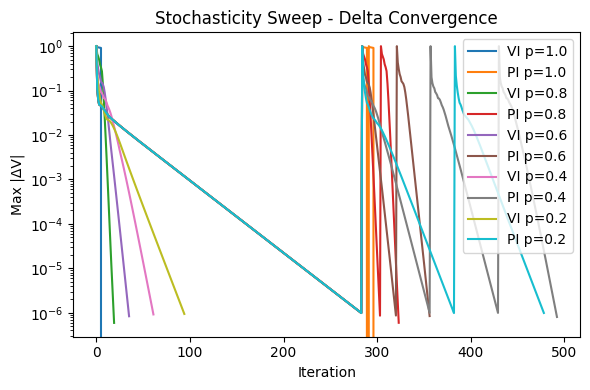

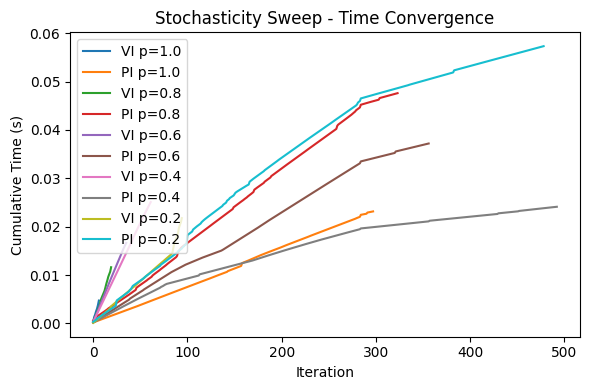

Plots saved to: outputs_dp_lab2/extra/stochasticity_sweep

=== EXTRA: Terminal Reward Sensitivity ===

--- terminal reward = 1 ---
  VI sweeps: 7 | final Δ = 0.00e+00
  Sample V: [0.71691065 0.76455621 0.81268304 0.76455621] ...

--- terminal reward = 2 ---
  VI sweeps: 7 | final Δ = 0.00e+00
  Sample V: [1.6679007  1.72515222 1.78298204 1.72515222] ...

--- terminal reward = 5 ---
  VI sweeps: 7 | final Δ = 0.00e+00
  Sample V: [4.52087085 4.60694025 4.69387904 4.60694025] ...

--- terminal reward = -1 ---
  VI sweeps: 36 | final Δ = 0.00e+00
  Sample V: [-1.18506945 -1.15663581 -1.12791496 -1.15663581] ...


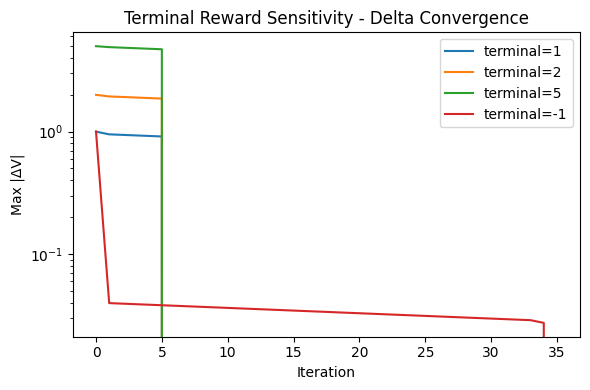

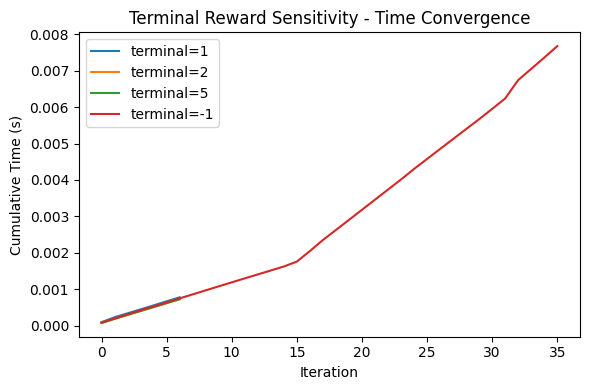

Plots saved to: outputs_dp_lab2/extra/terminal_rewards

=== EXTRA: Step-Cost Variation ===

--- step_cost = 0.0 ---
  VI sweeps: 7 | final Δ = 0.00e+00
  Sample V: [0.95099005 0.96059601 0.970299   0.96059601] ...

--- step_cost = -0.01 ---
  VI sweeps: 7 | final Δ = 0.00e+00
  Sample V: [0.8924702  0.91158606 0.93089501 0.91158606] ...

--- step_cost = -0.1 ---
  VI sweeps: 7 | final Δ = 0.00e+00
  Sample V: [0.36579154 0.47049651 0.5762591  0.47049651] ...


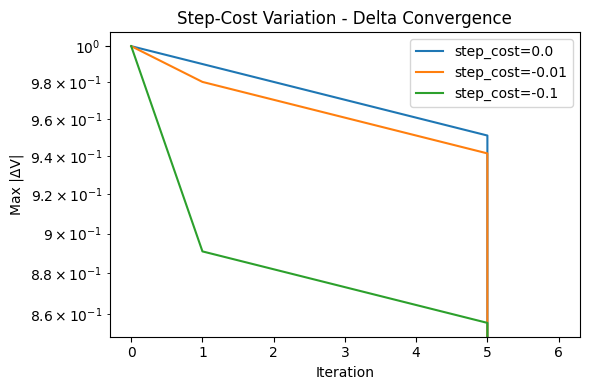

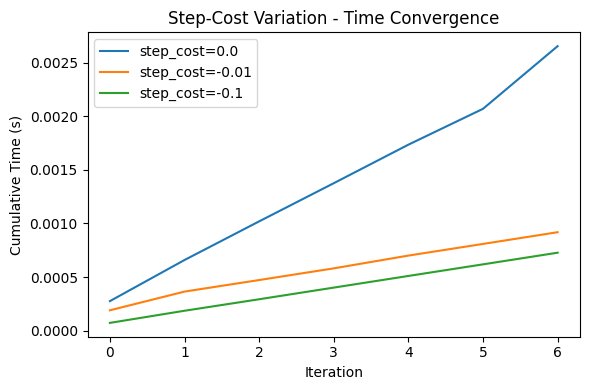

Plots saved to: outputs_dp_lab2/extra/step_cost

=== EXTRA: FrozenLake Comparison ===

--- FrozenLake is_slippery = False ---
  VI sweeps: 7 | final Δ = 0.00e+00
  Sample V: [0.95099005 0.96059601 0.970299   0.96059601] ...

--- FrozenLake is_slippery = True ---
  VI sweeps: 228 | final Δ = 9.72e-07
  Sample V: [0.54201404 0.49878743 0.47067727 0.45683193] ...


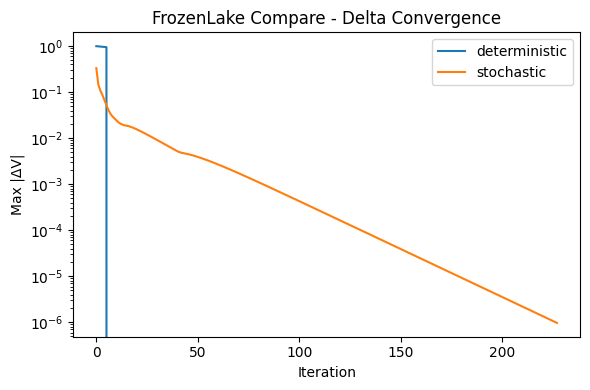

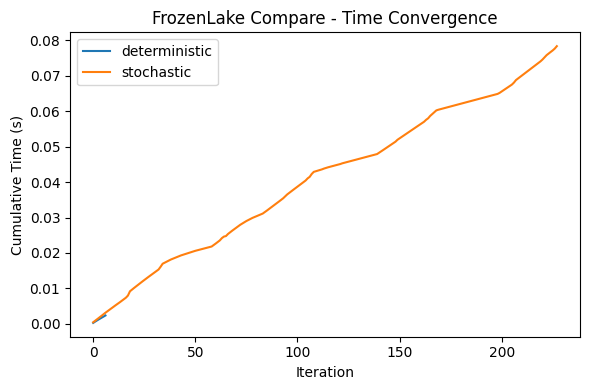

Plots saved to: outputs_dp_lab2/extra/frozenlake_compare

=== All EXTRA experiments completed! ===


In [6]:
run_all_extra_experiments()

## Extra Experiments – Summary and Analysis

To better understand how Dynamic Programming behaves under different conditions, I ran a set of extra experiments that extend the core lab requirements. First, I tested how increasing stochasticity affects convergence by gradually lowering the intended action probability. As the environment became more random, both Policy Iteration and Value Iteration converged more slowly, which makes sense because uncertainty makes value propagation less clear and Q-value differences shrink. I also experimented with different terminal rewards (+1, +2, +5, –1) to see how sensitive DP is to reward changes. Larger rewards pushed values higher across the grid and led to faster convergence, while negative terminal rewards flattened the value function and encouraged the agent to avoid the goal. I then varied the step cost (0, –0.01, –0.1) to observe how reward shaping affects the optimal behavior. Small negative step costs helped values propagate more cleanly and encouraged shorter paths, while larger penalties made the agent strongly prefer quick termination. Finally, I compared deterministic and stochastic versions of FrozenLake, where deterministic transitions converged quickly and the slippery version required more sweeps due to unpredictable outcomes. Overall, these extra tests showed that DP algorithms are highly sensitive to transition randomness and reward structure, which directly impacts convergence speed, policy stability, and the clarity of the optimal path.